In [1]:
##########################
# transfer learning using EfficientNetB7 as base model
# After training, the model shows more than 85% accuracy for validation dataset.
##########################

import numpy as np
from numpy import asarray
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers
#Use this to check if the GPU is configured correctly
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import pathlib
from keras.preprocessing.image import ImageDataGenerator
import shutil
import pandas as pd
from tqdm import tqdm
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11719639359931916159
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14291267453065546922
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2022-03-07 01:12:55.803456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 01:12:55.850651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:12:55.949086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:12:55.949814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
# set parameters:  when batch_size is large, out of memory happens.
batch_size = 16
img_height = 224  #500
img_width = 224
NUMBER_OF_CLASSES=10

#count total number of images
data_dir = pathlib.Path("../input/vehicleImage/vehicles")
image_count = len(list(data_dir.glob('*/*.JPEG')))
print(image_count)

#The tree structure of the files can be used to compile a class_names list.
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
class_id=range(len(class_names))
print(class_id)

13000
['Aircraft_Carrier' 'Airliner' 'Airship' 'Amphibius_Vehicle' 'Fireboat'
 'RV' 'Speedboat' 'Submarine' 'Tank' 'Warplane']
range(0, 10)


In [3]:
TRAIN_IMAGES_PATH = './train' 
VAL_IMAGES_PATH = './val' 
TEST_IMAGES_PATH = './test' 
External_DIR = '../input/vehicleImage/vehicles' 

os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)
os.makedirs(TEST_IMAGES_PATH, exist_ok = True)

# Create directories for each class.
for class_id in [x for x in range(len(class_names))]:
    os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(VAL_IMAGES_PATH, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(TEST_IMAGES_PATH, str(class_id)), exist_ok = True)  

In [4]:
directory_contents = os.listdir('./val')
print(directory_contents)

for item in directory_contents:
    if os.path.isdir(item):
        print(item)

['8', '6', '4', '7', '9', '5', '0', '3', '1', '2']


In [5]:
# copy to train, validation and test directory
class_id=-1
for class_name in class_names:
    class_id=class_id+1
    Input_dir = '../input/vehicleImage/vehicles/'+class_name
    data_dir = pathlib.Path(Input_dir)
    image_count = len(list(data_dir.glob('*.JPEG')))
    #print(image_count)
    
    #get the list of names of all the images and shuffle
    list_ds = tf.data.Dataset.list_files( Input_dir + "/*", shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
    
    #Split the dataset into training, validation, and test sets :
    slice_size = int(image_count * 0.1)
    train_ds = list_ds.take(slice_size)
    val_test_ds = list_ds.skip(slice_size)
    val_ds = val_test_ds.take(slice_size)
    test_ds = val_test_ds.skip(slice_size)
    
    for item in  train_ds.as_numpy_iterator():
        shutil.copy(item.decode("utf-8"), os.path.join(TRAIN_IMAGES_PATH, str(class_id)))

    for item in  val_ds.as_numpy_iterator():
        shutil.copy(item.decode("utf-8"), os.path.join(VAL_IMAGES_PATH, str(class_id)))

    for item in  test_ds.as_numpy_iterator():
        shutil.copy(item.decode("utf-8"), os.path.join(TEST_IMAGES_PATH, str(class_id)))

    print(Input_dir)    

2022-03-07 01:13:01.998739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:13:01.999563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:13:02.000196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:13:02.001131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 01:13:02.001768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

../input/vehicleImage/vehicles/Aircraft_Carrier
../input/vehicleImage/vehicles/Airliner
../input/vehicleImage/vehicles/Airship
../input/vehicleImage/vehicles/Amphibius_Vehicle
../input/vehicleImage/vehicles/Fireboat
../input/vehicleImage/vehicles/RV
../input/vehicleImage/vehicles/Speedboat
../input/vehicleImage/vehicles/Submarine
../input/vehicleImage/vehicles/Tank
../input/vehicleImage/vehicles/Warplane


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, 
# EfficientNetB3,... up to  7
# Higher the number, the more complex the model is. 
# and the larger resolutions it  can handle, but  the more GPU memory it will need
# loading pretrained conv base model
# input_shape is (height, width, number of channels) for images
input_shape=(img_height, img_width, 3)

conv_base = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    classes=NUMBER_OF_CLASSES,
    classifier_activation="softmax"
)


258088960/258076736 [==============================] - 4s 0us/step


In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# avoid overfitting
# model.add(layers.Dropout(rate=0.2, name="dropout_out"))
model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out"))
conv_base.trainable = True

In [8]:
# The ImageDataGenerator class allows us to specifiy 
# whatever augmentations we want so easily.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
# Note that the validation data should not be augmented!
# and a very important step is to normalise the images through  rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(img_height, img_width),
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical"
)
validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)


Found 1300 images belonging to 10 classes.
Found 1300 images belonging to 10 classes.


In [9]:
#Train the model:
epochs=30
NUMBER_OF_TRAINING_IMAGES=1300
NUMBER_OF_VALIDATION_IMAGES=1300
history = model.fit(
    train_generator,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=4
)

2022-03-07 01:14:48.552873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-07 01:15:37.011213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


81/81 [==============================] - 126s 883ms/step - loss: 3.4697 - acc: 0.1308 - val_loss: 4.1924 - val_acc: 0.1057
Epoch 2/30
81/81 [==============================] - 67s 826ms/step - loss: 2.5104 - acc: 0.2617 - val_loss: 3.6685 - val_acc: 0.1011
Epoch 3/30
81/81 [==============================] - 68s 820ms/step - loss: 1.9155 - acc: 0.3777 - val_loss: 4.0913 - val_acc: 0.0856
Epoch 4/30
81/81 [==============================] - 68s 821ms/step - loss: 1.5880 - acc: 0.4860 - val_loss: 4.1191 - val_acc: 0.0895
Epoch 5/30
81/81 [==============================] - 68s 824ms/step - loss: 1.3885 - acc: 0.5623 - val_loss: 3.0851 - val_acc: 0.1775
Epoch 6/30
81/81 [==============================] - 67s 816ms/step - loss: 1.1056 - acc: 0.6223 - val_loss: 2.3222 - val_acc: 0.3403
Epoch 7/30
81/81 [==============================] - 77s 937ms/step - loss: 0.9995 - acc: 0.6511 - val_loss: 1.6810 - val_acc: 0.5039
Epoch 8/30
81/81 [==============================] - 68s 823ms/step - loss: 0.88

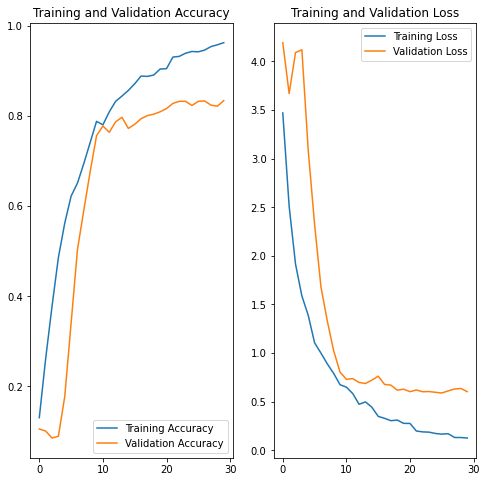

In [10]:
# Visualize training results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# functions that convert a file path to an (img, label) pair:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [12]:
# get the list of names of all the images
test_ds1 = tf.data.Dataset.list_files(TEST_IMAGES_PATH+"/*/*", shuffle=False)
val_ds1 = tf.data.Dataset.list_files(VAL_IMAGES_PATH+"/*/*", shuffle=False)
AUTOTUNE = tf.data.AUTOTUNE
test_ds1 = test_ds1.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds1 = val_ds1.map(process_path, num_parallel_calls=AUTOTUNE)

Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 99.39 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Airliner with a 64.08 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Submarine with a 96.68 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Airship with a 29.25 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Amphibius_Vehicle with a 86.96 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 94.71 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 100.00 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 97.75 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 95.99 percent confidence.
Label:  0
Aircraft_Carr

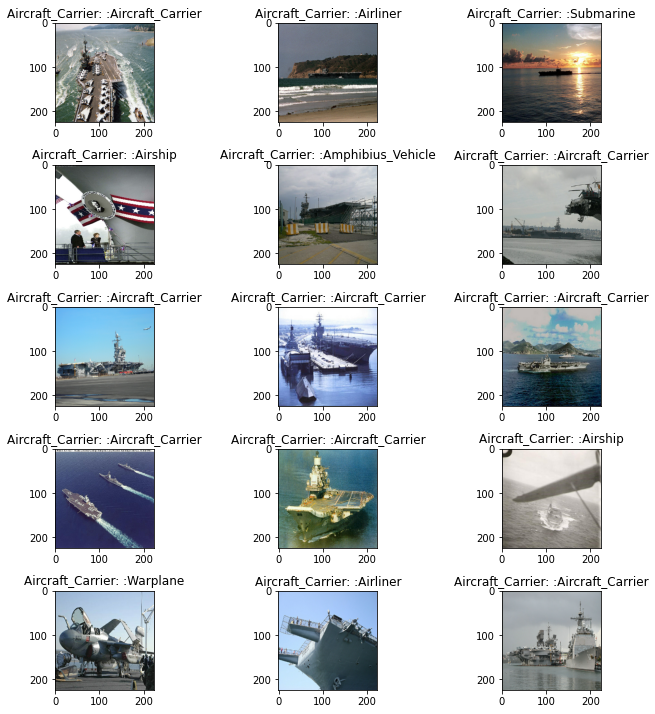

In [13]:
# predict validation data
plt.figure(figsize=(10, 10))
i=-1
for image, label in val_ds1.take(15):
    i=i+1
    print("Label: ", label.numpy())
    print(class_names[label])
    predictions = model.predict(np.expand_dims(image/255, axis=0))
    #score = tf.nn.softmax(predictions[0])
    score =predictions[0]
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    ax = plt.subplot(5, 3, i + 1)
    plt.tight_layout(pad=1.0)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label] +": :"+ class_names[np.argmax(score)])

Label:  0
Aircraft_Carrier
This image most likely belongs to Submarine with a 49.54 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 99.99 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 99.16 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 98.06 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Tank with a 33.25 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 95.71 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 100.00 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Airliner with a 20.18 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 99.85 percent confidence.
Label:  0
Aircraft_Carrier


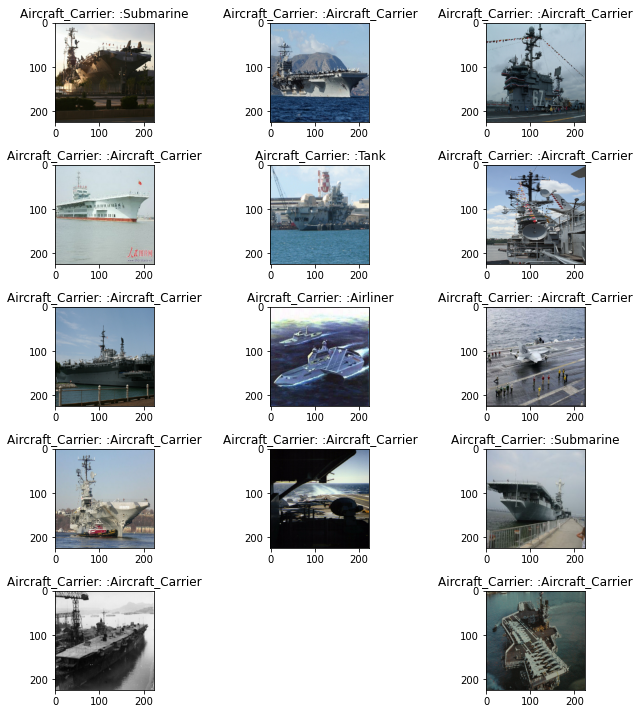

In [14]:
# predict test data

plt.figure(figsize=(10, 10))
i=-1
for image, label in test_ds1.take(15):
    i=i+1
    print("Label: ", label.numpy())
    print(class_names[label])
    predictions = model.predict(np.expand_dims(image/255, axis=0))
    score = predictions[0]
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    plt.tight_layout(pad=1.0)
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label] +": :"+ class_names[np.argmax(score)])

In [15]:
##########################
# Vanilla model without enhanced techniques. about 50% accuracy for validation data
##########################

In [16]:
import numpy as np
from numpy import asarray
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
from sklearn.model_selection import StratifiedKFold
import pathlib
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [17]:
# set parameters
batch_size = 32
img_height = 224 #224  #500
img_width = 224

#count total number of images
data_dir = pathlib.Path("../input/vehicleImage/vehicles")
image_count = len(list(data_dir.glob('*/*.JPEG')))
print(image_count)

#get the list of names of all the images and shuffle
list_ds = tf.data.Dataset.list_files("../input/vehicleImage/vehicles/*/*", shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

#The tree structure of the files can be used to compile a class_names list.
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

13000
['Aircraft_Carrier' 'Airliner' 'Airship' 'Amphibius_Vehicle' 'Fireboat'
 'RV' 'Speedboat' 'Submarine' 'Tank' 'Warplane']


In [18]:
#Split the dataset into training, validation, and test sets:
slice_size = int(image_count * 0.3)
train_ds = list_ds.take(slice_size)
val_test_ds = list_ds.skip(slice_size)
val_ds = val_test_ds.take(slice_size)
test_ds = val_test_ds.skip(slice_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

3900
3900
5200


In [19]:
# functions that convert a file path to an (img, label) pair:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [20]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1


2022-03-07 01:53:58.726391: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


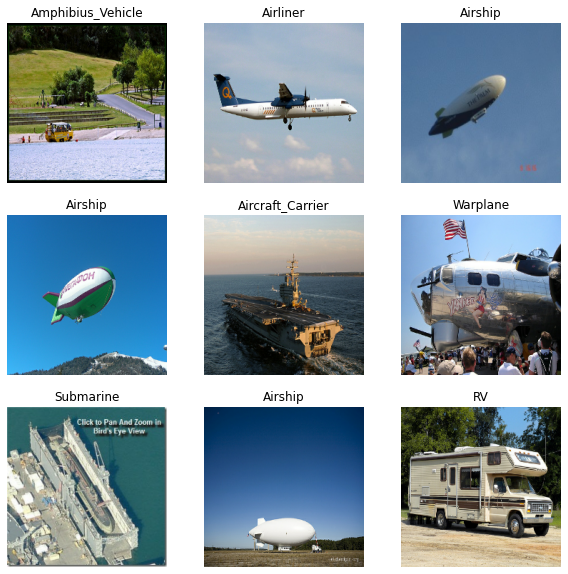

In [21]:
#Configure dataset for performance
#To be well shuffled.
#To be batched.
#Batches to be available as soon as possible.

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

#Visualize the data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [22]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
#training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
122/122 [==============================] - 27s 200ms/step - loss: 2.1426 - accuracy: 0.2069 - val_loss: 1.9292 - val_accuracy: 0.3177
Epoch 2/10
122/122 [==============================] - 5s 38ms/step - loss: 1.7028 - accuracy: 0.3982 - val_loss: 1.7710 - val_accuracy: 0.3905
Epoch 3/10
122/122 [==============================] - 4s 34ms/step - loss: 1.3668 - accuracy: 0.5259 - val_loss: 1.7179 - val_accuracy: 0.4179
Epoch 4/10
122/122 [==============================] - 4s 33ms/step - loss: 0.9996 - accuracy: 0.6718 - val_loss: 2.0226 - val_accuracy: 0.4174
Epoch 5/10
122/122 [==============================] - 4s 34ms/step - loss: 0.6055 - accuracy: 0.8046 - val_loss: 2.2612 - val_accuracy: 0.4182
Epoch 6/10
122/122 [==============================] - 4s 33ms/step - loss: 0.3053 - accuracy: 0.9072 - val_loss: 2.9177 - val_accuracy: 0.4062
Epoch 7/10
122/122 [==============================] - 4s 33ms/step - loss: 0.1556 - accuracy: 0.9551 - val_loss: 3.6195 - val_accuracy: 0.40

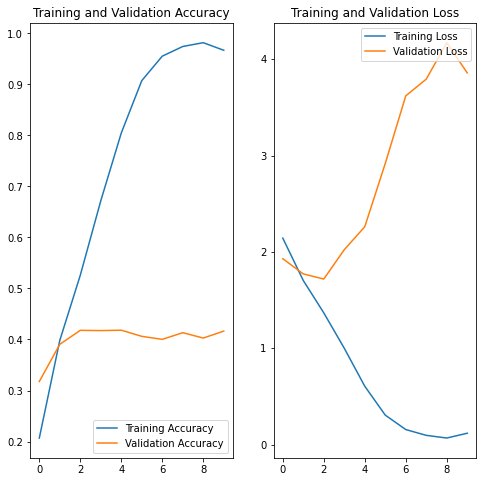

In [24]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to Airship with a 98.03 percent confidence.
This image most likely belongs to Aircraft_Carrier with a 98.36 percent confidence.
This image most likely belongs to Fireboat with a 72.84 percent confidence.
This image most likely belongs to Airliner with a 95.83 percent confidence.
This image most likely belongs to Amphibius_Vehicle with a 80.27 percent confidence.
This image most likely belongs to Tank with a 95.52 percent confidence.
This image most likely belongs to Fireboat with a 86.60 percent confidence.
This image most likely belongs to Warplane with a 49.60 percent confidence.
This image most likely belongs to Aircraft_Carrier with a 92.86 percent confidence.


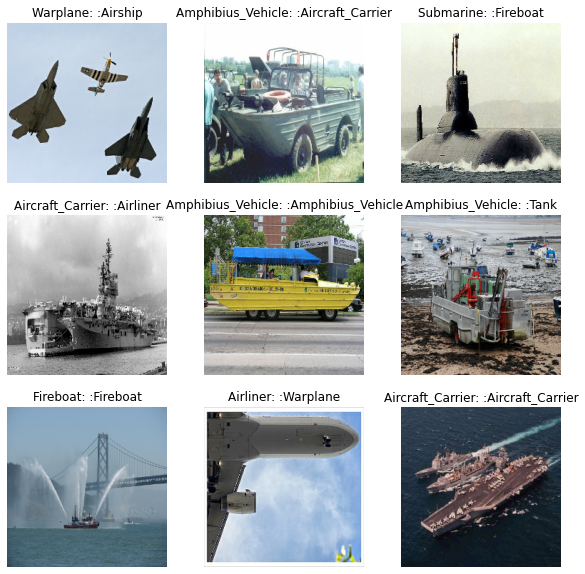

In [25]:
#Visualize the data
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    predictions = model.predict(np.expand_dims(image_batch[i], axis=0))
    score = tf.nn.softmax(predictions[0])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label] +": :"+ class_names[np.argmax(score)])
    plt.axis("off")

Label:  5
RV
This image most likely belongs to RV with a 93.17 percent confidence.
Label:  3
Amphibius_Vehicle
This image most likely belongs to Amphibius_Vehicle with a 62.87 percent confidence.
Label:  1
Airliner
This image most likely belongs to Submarine with a 99.87 percent confidence.
Label:  7
Submarine
This image most likely belongs to Submarine with a 97.82 percent confidence.
Label:  3
Amphibius_Vehicle
This image most likely belongs to Aircraft_Carrier with a 62.02 percent confidence.
Label:  7
Submarine
This image most likely belongs to Submarine with a 92.89 percent confidence.
Label:  1
Airliner
This image most likely belongs to Airship with a 84.03 percent confidence.
Label:  0
Aircraft_Carrier
This image most likely belongs to Aircraft_Carrier with a 94.74 percent confidence.
Label:  7
Submarine
This image most likely belongs to Fireboat with a 87.15 percent confidence.
Label:  1
Airliner
This image most likely belongs to Warplane with a 99.23 percent confidence.
Label:

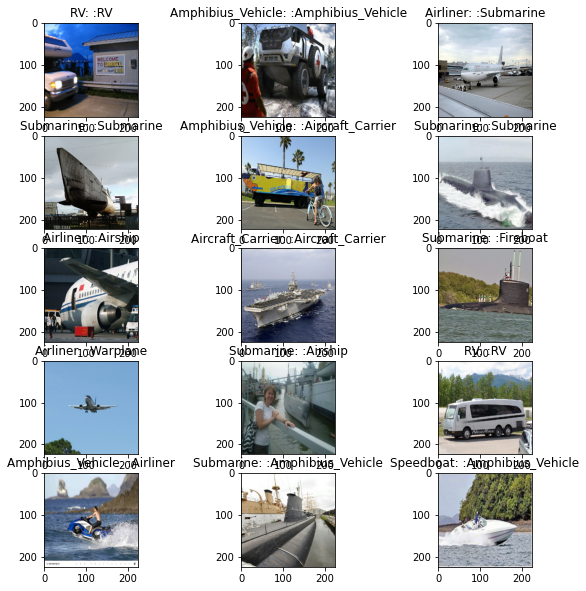

In [26]:
plt.figure(figsize=(10, 10))
i=-1
for image, label in test_ds.take(15):
    i=i+1
    print("Label: ", label.numpy())
    print(class_names[label])
    predictions = model.predict(np.expand_dims(image, axis=0))
    score = tf.nn.softmax(predictions[0])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label] +": :"+ class_names[np.argmax(score)])

In [27]:
##########################
# use pre-trained MobileNet without transfer learning.
# 95.7% accuracy for Aircraft_Carrier
# 93.2% accuracy for fireboat
# 100% accuracy for dozen of pictires I took.
##########################

import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense, Activation
#from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import preprocess_input
#tf.keras.applications
import numpy as np
from IPython.display import Image

#from keras.applications import MobileNet


In [28]:
mobile = tf.keras.applications.MobileNetV2()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

14548992/14536120 [==============================] - 0s 0us/step


In [29]:
# predict Aircraft_Carrier: 1244/1300=95.7%
# get the list of names of all the images and shuffle
list_ds = tf.data.Dataset.list_files("../input/vehicleImage/vehicles/Aircraft_Carrier/*", shuffle=False)
count=0
correct=0
for f in list_ds:
    count=count+1
    preprocessed_image = prepare_image(f.numpy().decode("utf-8"))
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
    if results[0][0][1] == "aircraft_carrier" :
        correct=correct+1
print(count)
print(correct)

49152/35363 [=========================================] - 0s 0us/step
1300
1244


In [30]:
# predict fireboat: 1212/1300=93.2%
# get the list of names of all the images and shuffle                                
list_ds = tf.data.Dataset.list_files("../input/vehicleImage/vehicles/Fireboat/*", shuffle=False)
count=0
correct=0                                    
                                     
count=0
correct=0
for f in list_ds:
    count=count+1
    preprocessed_image = prepare_image(f.numpy().decode("utf-8"))
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
    if results[0][0][1] == "fireboat" :
        correct=correct+1
print(count)
print(correct)

1300
1212


[[('n03344393', 'fireboat', 0.9328971), ('n03874293', 'paddlewheel', 0.0014869706), ('n03095699', 'container_ship', 0.0012747665), ('n03673027', 'liner', 0.0012397586), ('n03216828', 'dock', 0.0011263784)]]


Text(0.5, 1.0, 'predicted as:fireboat')

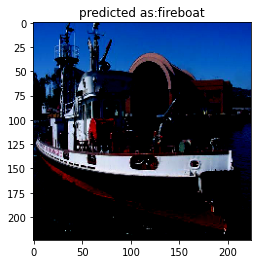

In [31]:
preprocessed_image = prepare_image('../input/vehicleImage/vehicles/Fireboat/n03344393_10001.JPEG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)
plt.imshow(preprocessed_image[0])
plt.title("predicted as:"+ results[0][0][1])

[[('n02091134', 'whippet', 0.44024408), ('n02108915', 'French_bulldog', 0.0710461), ('n02123597', 'Siamese_cat', 0.05860951), ('n02093428', 'American_Staffordshire_terrier', 0.03311924), ('n02110958', 'pug', 0.03311761)]]


Text(0.5, 1.0, 'predicted as:whippet')

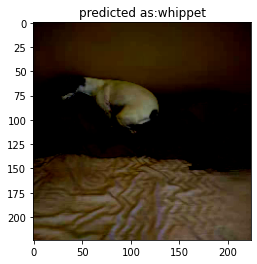

In [32]:
preprocessed_image = prepare_image('../input/random/image/551eb20af2c474321f324598de76232.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)
plt.imshow(preprocessed_image[0])
plt.title("predicted as:"+ results[0][0][1])

[[('n02091134', 'whippet', 0.19326167), ('n02110958', 'pug', 0.17343396), ('n02108915', 'French_bulldog', 0.09164145), ('n04033995', 'quilt', 0.074249715), ('n02804414', 'bassinet', 0.047549054)]]


Text(0.5, 1.0, 'predicted as:whippet')

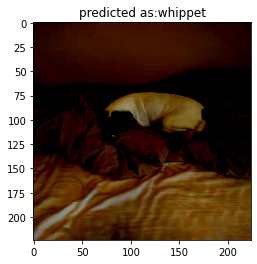

In [33]:
preprocessed_image = prepare_image('../input/random/image/f8e9ce997b5c2088926d2c157db25fa.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)
plt.imshow(preprocessed_image[0])
plt.title("predicted as:"+ results[0][0][1])